<a href="https://colab.research.google.com/github/so3500/2024-spark/blob/main/PySpark_study_playground_by_ON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare Environment

Install Dependencies:


1.   Java 8
2.   Apache Spark with hadoop and
3.   Findspark (used to locate the spark in the system)

> If you have issues with spark version, please upgrade to the latest version from [here](https://archive.apache.org/dist/spark/).

In [1]:
### java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

### spark & pyspark
#!wget -q http://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!cp /content/drive/MyDrive/2024_pyspark/spark-3.5.1-bin-hadoop3.tgz /content/
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark

### test data
!cp -r /content/drive/MyDrive/2024_pyspark/movie_data /content/

Set Environment Variables:

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, year, datediff, expr, min, max, filter, count_if, when
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType
from pyspark.sql.functions import to_date

spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

# Loading Dataset
- movie
- ratings
- usser
- movie_generes

In [4]:
# Load data from csv to a dataframe.
# header=True means the first row is a header
# sep=';' means the column are seperated using ''

### movie ###
movie_labels = [
    ('movie_id', IntegerType()),
    ('title', StringType()),
    ('genres', StringType())
]
movie_schema = StructType([StructField (x[0], x[1], True) for x in movie_labels])
movie_df = spark.read.csv('movie_data/movie.csv', header=True, sep=",", schema=movie_schema)
movie_df.show(3)
movie_df.printSchema()
# movie_df.select(max(movie_df.movie_id)).show()

### movie_genres ###
movie_genres_labels = [
    ('mgenre_id', IntegerType()),
    ('movie_id', IntegerType()),
    ('genre', StringType())
]
movie_genres_schema = StructType([StructField (x[0], x[1], True) for x in movie_genres_labels])
movie_genres_df = spark.read.csv('movie_data/movie_genres.csv', header=True, sep=",", schema=movie_genres_schema)
movie_genres_df.show(3)
movie_genres_df.printSchema()
# remove duplication
movie_genres_df = movie_genres_df.dropDuplicates(subset=['movie_id', 'genre'])

### ratings ###
ratings_labels = [
    ('rating_id', IntegerType()),
    ('user_id', IntegerType()),
    ('movie_id', IntegerType()),
    ('rating', IntegerType()),
    ('timestamp', TimestampType())
]
ratings_schema = StructType([StructField (x[0], x[1], True) for x in ratings_labels])
ratings_df = spark.read.csv('movie_data/ratings.csv', header=True, sep=",", schema=ratings_schema)
ratings_df.show(3)
ratings_df.printSchema()
# ratings_df.select(max(ratings_df.user_id)).show()
# ratings_df.select(max(ratings_df.movie_id)).show()
# ratings_df.select(max(ratings_df.rating)).show()

### user ###
user_labels = [
    ('user_id', IntegerType()),
    ('age', IntegerType()),
    ('gender', StringType()),
    ('occupation', StringType()),
    ('zip_code', IntegerType())
]
user_schema = StructType([StructField (x[0], x[1], True) for x in user_labels])
user_df = spark.read.csv('movie_data/user.csv', header=True, sep=",", schema=user_schema)
user_df.show(3)
user_df.printSchema()

+--------+-----------------+---------+
|movie_id|            title|   genres|
+--------+-----------------+---------+
|       1| Toy Story (1995)|01-Jan-95|
|       2| GoldenEye (1995)|01-Jan-95|
|       3|Four Rooms (1995)|01-Jan-95|
+--------+-----------------+---------+
only showing top 3 rows

root
 |-- movie_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+---------+--------+-------+
|mgenre_id|movie_id|  genre|
+---------+--------+-------+
|        1|     267|unknown|
|        2|    1373|unknown|
|        3|       2| Action|
+---------+--------+-------+
only showing top 3 rows

root
 |-- mgenre_id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- genre: string (nullable = true)

+---------+-------+--------+------+-------------------+
|rating_id|user_id|movie_id|rating|          timestamp|
+---------+-------+--------+------+-------------------+
|        1|    196|     242|     3|1997-12-04 15:55:00|
| 

# **분석1: 특정 사용자 그룹의 영화 선호도 분석**
문제 설명
특정 연령대와 성별의 사용자들이 선호하는 영화 장르를 분석하십시오.

연령대: 20세에서 30세 사이
성별: 여성

1. ratings, movie_genres, user 테이블을 사용합니다.
2. 해당 연령대와 성별의 사용자들이 평가한 영화를 기준으로 분석합니다.
3. 각 장르별 영화의 평균 평점과 영화 수를 계산합니다.
4. 평균 평점이 높은 순서로 결과를 정렬합니다. 동일한 평점일 경우 영화 수가 많은 순서로 정렬합니다.

[결과 예시]

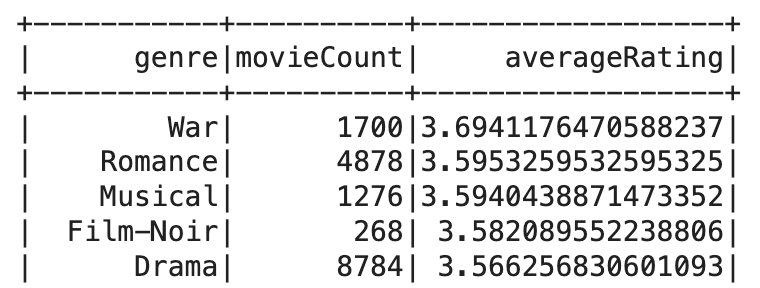

## 풀이

In [5]:
user_female_20s_df = user_df.filter("age >= 20 and age <= 30 and gender = 'F'")
movie_without_unknown_df = movie_genres_df.filter("genre != 'unknown'")

# join rating, movie_genres, user
genre_rating_df = user_female_20s_df.join(ratings_df, user_female_20s_df.user_id == ratings_df.user_id, 'inner')\
  .join(movie_without_unknown_df, ratings_df.movie_id == movie_without_unknown_df.movie_id, 'inner')\
  .select(movie_genres_df.genre, movie_genres_df.movie_id, ratings_df.rating_id, ratings_df.rating)
genre_rating_df.show(5)

# aggregation
genre_rating_df.createOrReplaceTempView("genre_rating")
spark.sql("SELECT genre, COUNT(1) AS movice_count, SUM(rating)/COUNT(1) AS average_rating  \
 FROM genre_rating \
 GROUP BY genre \
 ORDER BY average_rating DESC, movice_count DESC").show()


+----------+--------+---------+------+
|     genre|movie_id|rating_id|rating|
+----------+--------+---------+------+
| Adventure|     465|        8|     5|
|   Romance|     465|        8|     5|
|Children's|     465|        8|     5|
|    Comedy|     257|       11|     2|
|    Action|     257|       11|     2|
+----------+--------+---------+------+
only showing top 5 rows



genre,movice_count,average_rating
War,850,3.6941176470588237
Romance,2439,3.5953259532595325
Musical,638,3.5940438871473352
Film-Noir,134,3.582089552238806
Drama,4392,3.566256830601093
Animation,497,3.545271629778672
Crime,776,3.506443298969072
Documentary,69,3.463768115942029
Mystery,489,3.4519427402862988
Adventure,1402,3.412981455064194


## 분석1: Question
요약 : `movie_genres.csv` 에서 한 개의 영화가 여러개의 장르를 가진다. 그런데 (영화아이디, 장르) 쌍 중복 이슈가 있어 제거가 필요해보인다.

Toy Story(movie_id : 1) 이면서 아래 mgenreId 와 genre 를 가짐
- 389 : Animation
- 341 : Cildren's
- 553 : Comedy
- 3282 : Animation
- 3324 : Children's
- 3446 : Comedy
,  
이것을 어떻게 봐야할까?

하나의 영화가 여러개의 장르를 가질 수는 있다. (가족, 코미디)
그런데 (가족, 가족, 코미디, 코미디) 일 순 없다.

원본 데이터의 이슈로 보이는데 movie_genres > movie_id, genre 를 기준으로 중복 제거해야 할 것 같다.

현재 table 구조상 mgenre_id 는 다른 테이블과의 key 로 사용되지 않으므로 중복 제거 과정에서 유실되어도 이슈 없어보인다.

# **분석2: 고평점 영화와 저평점 영화의 특징 비교**
평균 평점이 높은 영화와 낮은 영화의 장르 분포를 비교하십시오.


1. ratings, movie_genres 테이블을 사용합니다.
2. 먼저 각 영화의 평균 평점을 계산합니다.
3. 평균 평점이 4.0 이상인 영화와 2.0 미만인 영화를 구분하여 장르 분포를 계산합니다.
4. 각 장르별로 고평점 영화와 저평점 영화의 개수를 비교하여 결과를 도출합니다.

[결과 예시]

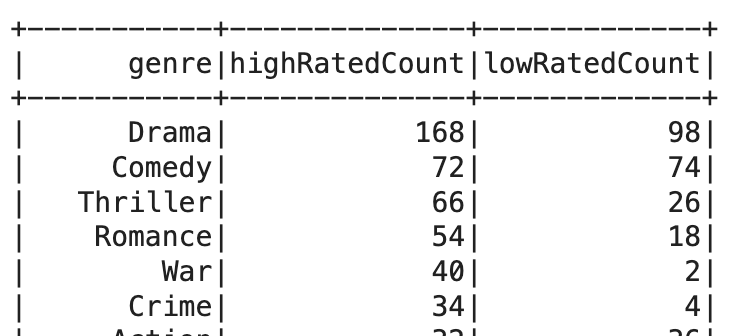

## 풀이

In [7]:
# prepare
average_ratings_df = ratings_df.groupBy("movie_id").agg(avg("rating").alias("average_rating"))
average_ratings_df.show(3)

# join
average_ratings_genres_df = average_ratings_df.join(movie_genres_df, average_ratings_df.movie_id == movie_genres_df.movie_id)
average_ratings_genres_df.show(3)

# result
average_ratings_genres_df.groupBy("genre").agg(
    count_if(col("average_rating") >= 4).alias("high_rated_count"),
    count_if(col("average_rating") < 2).alias("low_rated_count")
).orderBy("high_rated_count", ascending=False).show()

+--------+------------------+
|movie_id|    average_rating|
+--------+------------------+
|     496| 4.121212121212121|
|     471|3.6108597285067874|
|     463| 3.859154929577465|
+--------+------------------+
only showing top 3 rows

+--------+------------------+---------+--------+-----+
|movie_id|    average_rating|mgenre_id|movie_id|genre|
+--------+------------------+---------+--------+-----+
|     496| 4.121212121212121|     1402|     496|Drama|
|     471|3.6108597285067874|     2826|     471|  War|
|     471|3.6108597285067874|     1397|     471|Drama|
+--------+------------------+---------+--------+-----+
only showing top 3 rows

+-----------+----------------+---------------+
|      genre|high_rated_count|low_rated_count|
+-----------+----------------+---------------+
|      Drama|              84|             49|
|     Comedy|              36|             37|
|   Thriller|              33|             13|
|    Romance|              27|              9|
|        War|             

# **분석3: 사용자 활동 분석**
가장 많이 평점을 매긴 사용자 상위 10명과 그들의 평균 평점을 분석하십시오.

1. ratings 테이블을 사용합니다.
2. 각 사용자가 매긴 평점 수와 평균 평점을 계산합니다.
3. 평점 수가 많은 순서대로 상위 10명의 사용자와 그들의 평균 평점을 도출합니다.

[결과 예시]

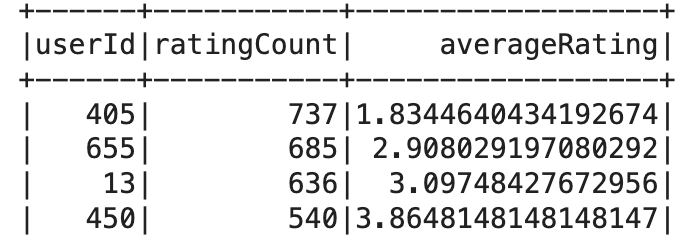

## 풀이

In [11]:
# prepare & result
ratings_agg_by_user_df = ratings_df.groupBy('user_id')\
  .agg(
      count('rating').alias('rating_count'),
      avg('rating').alias('average_rating')
      )\
  .orderBy('rating_count', ascending=False)\
  .show()

+-------+------------+------------------+
|user_id|rating_count|    average_rating|
+-------+------------+------------------+
|    405|         737|1.8344640434192674|
|    655|         685| 2.908029197080292|
|     13|         636|  3.09748427672956|
|    450|         540|3.8648148148148147|
|    276|         518| 3.465250965250965|
|    416|         493| 3.845841784989858|
|    537|         490|2.8653061224489798|
|    303|         484| 3.365702479338843|
|    234|         480| 3.122916666666667|
|    393|         448|3.3370535714285716|
|    181|         435|1.4919540229885058|
|    279|         434|3.2672811059907834|
|    429|         414| 3.393719806763285|
|    846|         405| 3.740740740740741|
|      7|         403| 3.965260545905707|
|     94|         400|            3.6575|
|    682|         399| 3.137844611528822|
|    308|         397|3.7581863979848866|
|     92|         388|3.2448453608247423|
|    293|         388|3.0309278350515463|
+-------+------------+------------

# **분석4: 특정 장르의 영화들에 대한 평점과 사용자 연령대 분석**
특정 장르의 영화에 대한 연령대별 평균 평점을 분석하십시오.

*   장르: 'Action'

1. ratings, user, movie_genres 테이블을 사용합니다.
2. 'Action' 장르의 영화를 평가한 사용자들의 연령대별 평균 평점을 계산합니다.
3. 연령대별 평균 평점을 연령 순으로 정렬하여 도출합니다.

[결과 예시]

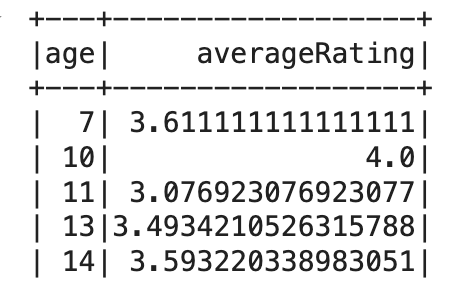

## 풀이

In [10]:
# prepare & join & result
movie_genres_df.filter('genre == "Action"')\
.join(ratings_df, movie_genres_df.movie_id == ratings_df.movie_id)\
.join(user_df, user_df.user_id == ratings_df.user_id)\
.select(user_df.age, ratings_df.rating)\
.groupBy('age')\
.agg(avg(ratings_df.rating).alias('average_rating'))\
.orderBy('age')\
.show()

+---+------------------+
|age|    average_rating|
+---+------------------+
|  7| 3.611111111111111|
| 10|               4.0|
| 11| 3.076923076923077|
| 13|3.4934210526315788|
| 14| 3.593220338983051|
| 15|               3.5|
| 16|3.5217391304347827|
| 17| 3.651006711409396|
| 18|3.7417677642980935|
| 19| 3.307101727447217|
| 20| 3.696747967479675|
| 21|3.4532760472610096|
| 22|3.2726432532347505|
| 23| 3.193243243243243|
| 24|3.4625199362041466|
| 25|3.5377952755905513|
| 26| 3.243414120126449|
| 27|3.4154676258992804|
| 28|3.4402907580477673|
| 29| 3.422773393461105|
+---+------------------+
only showing top 20 rows



# **분석5: 직업과 영화 관계 파헤치기**
1. 직업 별 많이 보는 영화 장르는?

결론 : 학생 직업군에서 영화를 가장 많이 본다.

In [ ]:
# user, rating, movie_genre
user_df.join(ratings_df, user_df.user_id == ratings_df.user_id)\
.join(movie_genres_df, movie_genres_df.movie_id == ratings_df.movie_id)\
.groupBy('occupation', 'genre').count()\
.orderBy('count', ascending=False)\
.show()

+-------------+---------+-----+
|   occupation|    genre|count|
+-------------+---------+-----+
|      student|    Drama| 7777|
|      student|   Comedy| 6958|
|      student|   Action| 6398|
|      student| Thriller| 5130|
|        other|    Drama| 4307|
|     educator|    Drama| 4281|
|      student|  Romance| 4156|
|      student|Adventure| 3358|
|        other|   Comedy| 3165|
|     engineer|    Drama| 3153|
|administrator|    Drama| 3099|
|      student|   Sci-Fi| 3069|
|   programmer|    Drama| 2800|
|     educator|   Comedy| 2708|
|        other|   Action| 2672|
|    librarian|    Drama| 2557|
|     engineer|   Comedy| 2438|
|   programmer|   Comedy| 2418|
|   programmer|   Action| 2322|
|        other| Thriller| 2321|
+-------------+---------+-----+
only showing top 20 rows



2. 직업 별 평균 평점을 구하고 내림차순 정렬한다.

결론 : 무직(none)을 제외하고 법률직무의 평균 평점이 가장 높다.


In [17]:
# user, rating
user_df.join(ratings_df, user_df.user_id == ratings_df.user_id)\
.groupBy('occupation').agg(avg(ratings_df.rating).alias('average_rating'))\
.peek(10)\
.orderBy('average_rating', ascending=False)\
.show()

Peeking at the first {} rows
+----------+------------------+
|occupation|    average_rating|
+----------+------------------+
| librarian| 3.560781338896264|
|   retired|3.4667495338719703|
|    lawyer|3.7353159851301116|
|      none| 3.779134295227525|
|    writer|3.3757225433526012|
|programmer|3.5682604794257147|
| marketing|3.4856410256410255|
|     other|3.5523773797242804|
| executive|3.3491037320011756|
| scientist| 3.611273080660836|
+----------+------------------+
only showing top 10 rows

+-------------+------------------+
|   occupation|    average_rating|
+-------------+------------------+
|         none| 3.779134295227525|
|       lawyer|3.7353159851301116|
|       doctor| 3.688888888888889|
|     educator|3.6706206312221985|
|       artist| 3.653379549393414|
|administrator|3.6356464768017114|
|    scientist| 3.611273080660836|
|     salesman| 3.582943925233645|
|   programmer|3.5682604794257147|
|    librarian| 3.560781338896264|
|        other|3.5523773797242804|
|     e

### Appendix

peek 함수 정의하기

In [13]:
from pyspark.sql.dataframe import DataFrame

# Define a Peek Function
def peek(self, n=10):
  print("Peeking at the first {} rows")
  self.show(n)
  return self

# Monkey Patch the DataFrame Calss
DataFrame.peek = peek